In [1]:
#Imports
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Encoder text to tensor
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') 
model = TFGPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id) 

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [43]:
#Get Yelp dataset and normalize 
reviews = pd.read_csv('bigreviews.csv')

#Normalization
for column in reviews:
    reviews['text'] = reviews['text'].str.lower()   #Covert the text to lower case
    reviews['text'].str.replace('[^\w\s]','') #Remove punctuation
    reviews['text'].str.strip() #Remove whitespace
    reviews['text'].str.replace("\n", " ") #Remove escape characters
reviews = reviews['text']

print(reviews)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_29240\3859494564.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['text'].str.replace('[^\w\s]','') #Remove punctuation


0         if you decide to eat here, just be aware it is...
1         i've taken a lot of spin classes over the year...
2         family diner. had the buffet. eclectic assortm...
3         wow!  yummy, different,  delicious.   our favo...
4         cute interior and owner (?) gave us tour of up...
                                ...                        
499995    we won the playoff game last night and is sche...
499996    we have been a resident almost 4 years at manz...
499997    this place is hyped as one of the best places ...
499998    saw the reviews so thought i'd try this place....
499999    yummy!  i ordered uber eats and wasn't sure ho...
Name: text, Length: 500000, dtype: object


In [3]:
#Segment the first section for model
df1 = reviews[:35000]

**Method**

From attempts to run the model as a whole, have had issues trying to run the large model and save weights due to the time to run epochs along with saving the dataframe, in attempt will train large model in chunks of 35k at a time and run the model using saved weights

In [3]:
#turn the entire reviews set into a long string to be segmented in next sequence
def stringify_tokenize(dataframe):
  single_string = ''
  for row in dataframe:
    x = row
    single_string += x 
  string_tokenized = tokenizer.encode(single_string)
  return string_tokenized

In [ ]:
def datasetCreate(string_tokenized):
  #Define variables to store the data
  revs = []
  inputs, labels = [], [] 
  block_size = 100
  BATCH_SIZE = 12 
  BUFFER_SIZE = 1000
  #Split the string_tokenized list into blocks of size block_size
  #store each block in the examples list
  for i in range(0, len(string_tokenized) - block_size + 1, block_size):
    revs.append(string_tokenized[i:i + block_size])


  #For each review in the ist, store the input as the example without the last part
  for rev in revs:
    inputs.append(rev[:-1])
    labels.append(rev[1:])

  #Create a dataset from the inputs and labels 
  dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))

  #Shuffle the dataset and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  return dataset

In [25]:
checkpoint_filepath = 'tmp3/weights.{epoch:02d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='auto',
    save_best_only=True)

In [2]:
#Compiler
def modelcompile(model):    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(loss=[loss],optimizer='adam',metrics=[metric])

In [7]:
#plot of the accuracy
def plot_acc():
    history_dict = history.history
    history_dict.keys() # the data gathered during training
    plt.clf()
    acc = history_dict['accuracy']
    epochs = range(1, len(acc) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, acc, solid_blue_line, label = 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#plot of the loss
def plot_loss():
    history_dict = history.history
    history_dict.keys()
    loss = history_dict['loss']
    epochs = range(1, len(loss) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, loss, solid_blue_line, label = 'Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3788/3788 [==============================] - 760s 198ms/step - loss: 3.8791 - accuracy: 0.2836
Epoch 2/15
3788/3788 [==============================] - 735s 194ms/step - loss: 3.5623 - accuracy: 0.3096
Epoch 3/15
3788/3788 [==============================] - 722s 191ms/step - loss: 3.3303 - accuracy: 0.3304
Epoch 4/15
3788/3788 [==============================] - 709s 187ms/step - loss: 3.1144 - accuracy: 0.3521
Epoch 5/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.9103 - accuracy: 0.3755
Epoch 6/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.7203 - accuracy: 0.3993
Epoch 7/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.5455 - accuracy: 0.4232
Epoch 8/15
3788/3788 [==============================] - 695s 183ms/step - loss: 2.3855 - accuracy: 0.4463
Epoch 9/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.2386 - accuracy: 0.4690
Epoch 10/15
3788/3788 [=======================

**Check Results**

In [ ]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [13]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3788/3788 [==============================] - 873s 230ms/step - loss: 1.4904 - accuracy: 0.6032
Epoch 2/15
3788/3788 [==============================] - 1030s 272ms/step - loss: 1.4131 - accuracy: 0.6187
Epoch 3/15
3788/3788 [==============================] - 719s 190ms/step - loss: 1.3421 - accuracy: 0.6337
Epoch 4/15
3788/3788 [==============================] - 698s 184ms/step - loss: 1.2749 - accuracy: 0.6479
Epoch 5/15
3788/3788 [==============================] - 687s 181ms/step - loss: 1.2142 - accuracy: 0.6618
Epoch 6/15
3788/3788 [==============================] - 680s 179ms/step - loss: 1.1568 - accuracy: 0.6745
Epoch 7/15
3788/3788 [==============================] - 699s 184ms/step - loss: 1.1032 - accuracy: 0.6869
Epoch 8/15
3788/3788 [==============================] - 687s 181ms/step - loss: 1.0537 - accuracy: 0.6986
Epoch 9/15
3788/3788 [==============================] - 708s 187ms/step - loss: 1.0079 - accuracy: 0.7094
Epoch 10/15
3788/3788 [======================

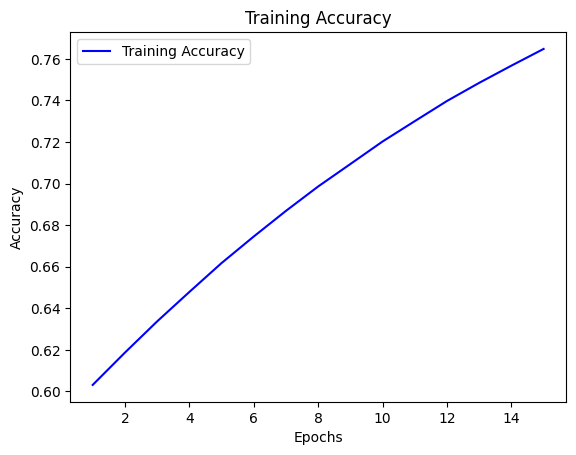

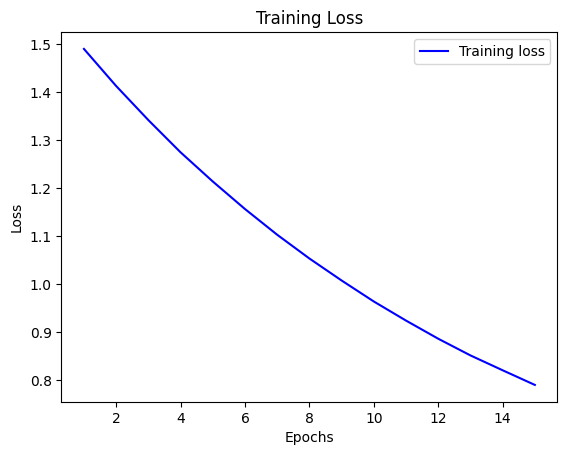

15


In [15]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

**Reload model with saved weights**

*Train on next segment of dataset*

In [14]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)

print(tokenizer.decode(output[0]))

i found the staff to be very friendly and helpful.  

i was in and out in less than an hour. they were able to get me in right away. i will definitely use them again.i have been here twice and both times were excellent. the food is delicious and the service is top-notch. if you're looking for a quick bite to eat, this is the place for you.this place is awesome! i came here with a group of friends and we nothing nothing like like nothing extra like such like extra nothing spot like, like spot nothing special nothing friendly nothing such nothing, extra extra spot friendly like other nothing while like friendly, nothing. nothing t like. like special like t nothing house extra such such


In [4]:
#Segment the second section for model
df2 = reviews[35000:70000]

In [5]:
single_string = ''
for row in df2:
  x = row
  single_string += x 
string_tokenized = tokenizer.encode(single_string)

Token indices sequence length is longer than the specified maximum sequence length for this model (4492540 > 1024). Running this sequence through the model will result in indexing errors


In [12]:
dataset = datasetCreate(string_tokenized)

In [15]:
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)#not in use 
# definining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(loss=[loss],optimizer='adam',metrics=[metric])

In [14]:
model.load_weights('tmp\weights.15.h5')
model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124439808 
 r)                                                              
                                                                 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3764/3764 [==============================] - 719s 188ms/step - loss: 3.7258 - accuracy: 0.3080
Epoch 2/15
3764/3764 [==============================] - 675s 179ms/step - loss: 3.3376 - accuracy: 0.3418
Epoch 3/15
3764/3764 [==============================] - 673s 179ms/step - loss: 3.0312 - accuracy: 0.3741
Epoch 4/15
3764/3764 [==============================] - 704s 187ms/step - loss: 2.7532 - accuracy: 0.4067
Epoch 5/15
3764/3764 [==============================] - 705s 187ms/step - loss: 2.5063 - accuracy: 0.4393
Epoch 6/15
3764/3764 [==============================] - 704s 187ms/step - loss: 2.2924 - accuracy: 0.4696
Epoch 7/15
3764/3764 [==============================] - 688s 183ms/step - loss: 2.1104 - accuracy: 0.4977
Epoch 8/15
3764/3764 [==============================] - 687s 183ms/step - loss: 1.9526 - accuracy: 0.5232
Epoch 9/15
3764/3764 [==============================] - 698s 185ms/step - loss: 1.8165 - accuracy: 0.5464
Epoch 10/15
3764/3764 [=======================

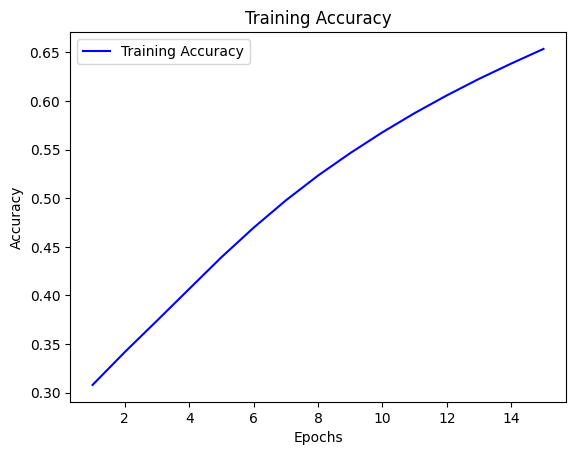

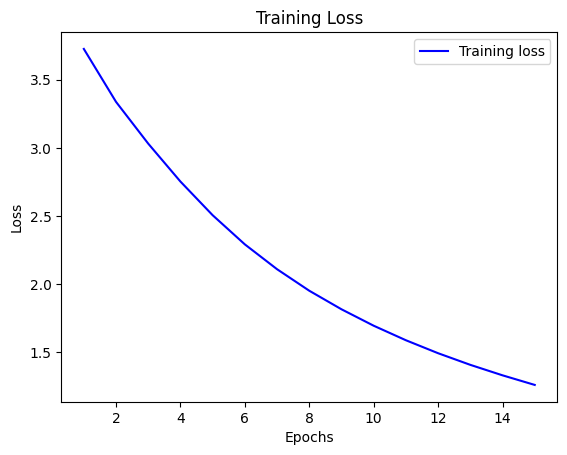

15


In [18]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [19]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3764/3764 [==============================] - 688s 183ms/step - loss: 1.1983 - accuracy: 0.6672
Epoch 2/15
3764/3764 [==============================] - 696s 185ms/step - loss: 1.1406 - accuracy: 0.6802
Epoch 3/15
3764/3764 [==============================] - 758s 201ms/step - loss: 1.0864 - accuracy: 0.6926
Epoch 4/15
3764/3764 [==============================] - 788s 209ms/step - loss: 1.0382 - accuracy: 0.7035
Epoch 5/15
3764/3764 [==============================] - 723s 192ms/step - loss: 0.9922 - accuracy: 0.7143
Epoch 6/15
3764/3764 [==============================] - 677s 180ms/step - loss: 0.9511 - accuracy: 0.7245
Epoch 7/15
3764/3764 [==============================] - 674s 179ms/step - loss: 0.9123 - accuracy: 0.7338
Epoch 8/15
3764/3764 [==============================] - 675s 179ms/step - loss: 0.8770 - accuracy: 0.7428
Epoch 9/15
3764/3764 [==============================] - 674s 179ms/step - loss: 0.8440 - accuracy: 0.7514
Epoch 10/15
3764/3764 [=======================

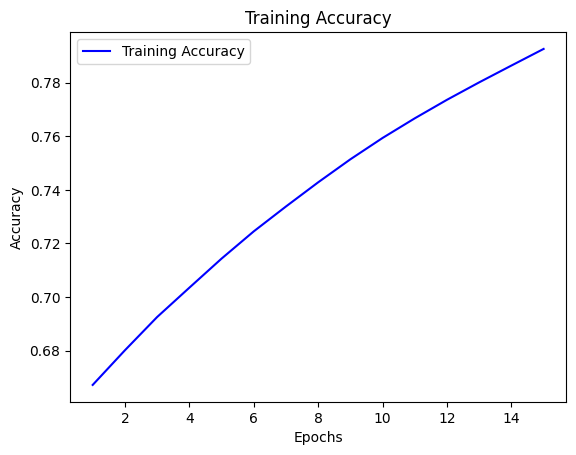

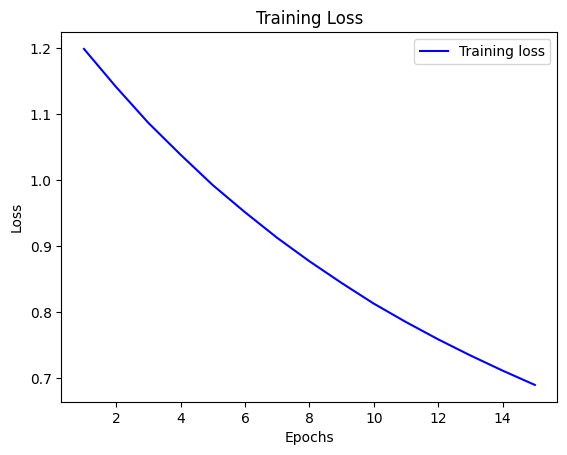

15


In [20]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [22]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.85,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)

print(tokenizer.decode(output[0]))

i found them to be professional, honest and honest. i had a great experience with them due to my insurance company emergency issues. they replaced a set of keys, problem corrected problem, and my wife's car was ready for pick up in 2 hours when promised. great deal! i highly recommend.i have been going to the men's room since it opened and each time i am not disappointed.  the food is a-maze-ing! and the cookies! wow, are this good a party in my new or bad one?  now gone now that i must have gone!

twice cream of my favorite restaurant again! :/enjoyedges are we are out of so many great foodies in nashville


*Third Segment*

In [5]:
#Segment the third section for model
df3 = reviews[70000:105000]
single_string = ''
for row in df3:
  x = row
  single_string += x 
string_tokenized = tokenizer.encode(single_string)

Token indices sequence length is longer than the specified maximum sequence length for this model (4491353 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
dataset = datasetCreate(string_tokenized)

In [12]:
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)#not in use 
# definining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(loss=[loss],optimizer='adam',metrics=[metric])
model.load_weights('tmp\weights.15.h5')

In [14]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
3742/3742 [==============================] - 698s 184ms/step - loss: 3.6800 - accuracy: 0.3135
Epoch 2/30
3742/3742 [==============================] - 662s 177ms/step - loss: 3.3156 - accuracy: 0.3466
Epoch 3/30
3742/3742 [==============================] - 659s 176ms/step - loss: 3.0318 - accuracy: 0.3770
Epoch 4/30
3742/3742 [==============================] - 659s 176ms/step - loss: 2.7701 - accuracy: 0.4081
Epoch 5/30
3742/3742 [==============================] - 751s 201ms/step - loss: 2.5321 - accuracy: 0.4394
Epoch 6/30
3742/3742 [==============================] - 755s 202ms/step - loss: 2.3200 - accuracy: 0.4693
Epoch 7/30
3742/3742 [==============================] - 703s 188ms/step - loss: 2.1349 - accuracy: 0.4975
Epoch 8/30
3742/3742 [==============================] - 664s 177ms/step - loss: 1.9731 - accuracy: 0.5233
Epoch 9/30
3742/3742 [==============================] - 674s 180ms/step - loss: 1.8325 - accuracy: 0.5468
Epoch 10/30
3742/3742 [=======================

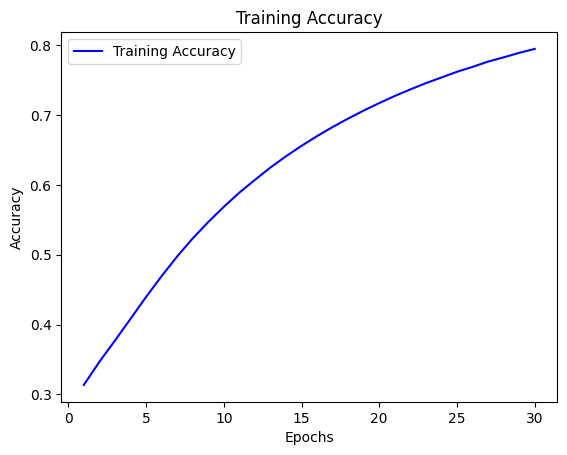

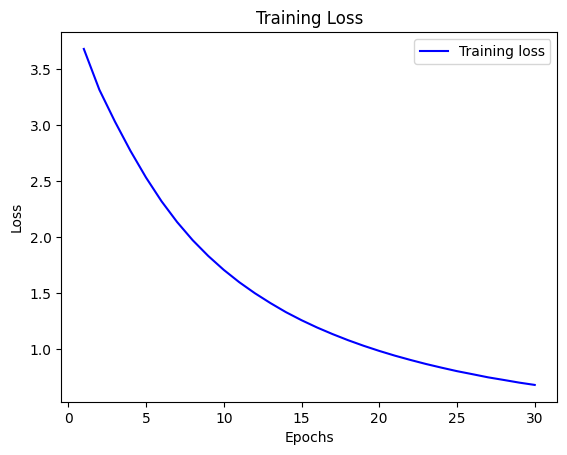

30


In [15]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [23]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is perfect!  even better migas than i've had in austin.  great rhythm to the place. must be owned by a drummer.

worth the wait, if you miss this place there will be trouble, boys.(this review is for the food only, not the music venues)
i've only been here once for lunch, but it was pretty crowded when i was there for dinner, the space is smaller than the dining room appears from the outside, and the indoor and i didn't know it looked at all the outdoor seating really liked the lighting was really clean that cause we were dressed up against the back ribs. my eyes, so that was just there were a toned open booths and there wasn't too bad seats a stagecozy inside. outside. service was a lot of the atmosphere, just a crunchy up close to gooey seats at first. inside and just enjoying the cool spot. friendly attentive, it did takeout dining space.


*Fourth Segment*

In [21]:
df4 = reviews[105000:140000]

In [20]:
#Segment the third section for model
single_string = ''
for row in df4:
  x = row
  single_string += x 
string_tokenized = tokenizer.encode(single_string)

In [9]:
dataset = datasetCreate(stringify_tokenize(df4))

Token indices sequence length is longer than the specified maximum sequence length for this model (4518808 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
modelcompile(model)

In [11]:
model.load_weights('tmp\weights.30.h5')

In [12]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
  62/3765 [..............................] - ETA: 12:15 - loss: 4.3034 - accuracy: 0.2734

*Fifth Segment*

*Note error with the save on notebook for segment 4, however was complete


In [9]:
df5 = reviews[140000:175000]

In [10]:
dataset = datasetCreate(stringify_tokenize(df5))

Token indices sequence length is longer than the specified maximum sequence length for this model (4463589 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
modelcompile(model)
model.load_weights('tmp\weights.30.h5')

In [12]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
3719/3719 [==============================] - 763s 202ms/step - loss: 3.7209 - accuracy: 0.3098
Epoch 2/30
3719/3719 [==============================] - 700s 188ms/step - loss: 3.3997 - accuracy: 0.3381
Epoch 3/30
3719/3719 [==============================] - 734s 197ms/step - loss: 3.1657 - accuracy: 0.3616
Epoch 4/30
3719/3719 [==============================] - 697s 187ms/step - loss: 2.9523 - accuracy: 0.3851
Epoch 5/30
3719/3719 [==============================] - 663s 178ms/step - loss: 2.7527 - accuracy: 0.4095
Epoch 6/30
3719/3719 [==============================] - 660s 177ms/step - loss: 2.5664 - accuracy: 0.4335
Epoch 7/30
3719/3719 [==============================] - 660s 177ms/step - loss: 2.3944 - accuracy: 0.4578
Epoch 8/30
3719/3719 [==============================] - 660s 177ms/step - loss: 2.2384 - accuracy: 0.4805
Epoch 9/30
3719/3719 [==============================] - 662s 178ms/step - loss: 2.0958 - accuracy: 0.5030
Epoch 10/30
3719/3719 [=======================

In [17]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is amazing and totally worth it. had the pho martini which was absolutely delicious. can't wait to go back and try the dinner menu. best vietnamese in the city. don't miss out on this place, it's worth the trip!very good service and even better delicious food. we ordered the buffalo style wings, blue plate, and bbq nachos. the wings were the best i have ever had, no other place makes them better. my husband and i had pork sandwich was definitely had brisketizer was excellent, regardless of the pulled pork sandwiches were delicious andoumi 12 oz. beer selection was so much better than most flavorful and it wasnthe maple syrup, this is not a great craft beer list had a heart attack on point, the breaded friends had such a very generous with a bit of course like most gcame to die for those wings covered in fact, def try at wagio's n.p meet my


In [18]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

i found this place on yelp.  typically i don't write reviews, but i felt compelled to do so on my trip here.

my friends and i came here for a mid-afternoon date with a friend, and we were both more than pleased with our experience. eating here is a bit of a bummer, because it's more on the small side and there's no host/wait staff and you order at the counter, or you can sit and eat there. but after your food in the next to go where there and it seems like a few minutes away from the hostess some time. if you'll beign chit was not really loud and chatty little while you do get take out in a table top table by the same dining room service isnt feel rushed out of course. so far away,  but the only to wait, so it took even better yet another 20 minutes after that way too long long. on a little bit pricey but not


In [19]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

never again 

1. food came out cold
2. my panera bread was warm
3. tasted plastic film better
4. be polite i finished my meal before i could even attempt to eat it
5. complained to the manager who had took it off the bill and brought me a free dessert that i didn't order,
6. when i went to pay i noticed my receipts were left at the table by the owners name and i wished i had never complained despite the way of this place.
overall this restaurant should have had such a 30 seconds away!!!!!!
i did not having this placethe
it was taking my experience.this wasntheated my dissatisfaction with an employee who i didnt know the


*Sixth Segment*

In [9]:
df6 = reviews[175000:205000]

In [10]:
dataset = datasetCreate(stringify_tokenize(df6))

Token indices sequence length is longer than the specified maximum sequence length for this model (3887943 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
modelcompile(model)
model.load_weights('tmp\weights.30.h5')

In [12]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
3239/3239 [==============================] - 595s 181ms/step - loss: 3.7368 - accuracy: 0.3083
Epoch 2/30
3239/3239 [==============================] - 581s 179ms/step - loss: 3.4215 - accuracy: 0.3360
Epoch 3/30
3239/3239 [==============================] - 577s 178ms/step - loss: 3.1928 - accuracy: 0.3589
Epoch 4/30
3239/3239 [==============================] - 577s 178ms/step - loss: 2.9833 - accuracy: 0.3820
Epoch 5/30
3239/3239 [==============================] - 577s 178ms/step - loss: 2.7864 - accuracy: 0.4053
Epoch 6/30
3239/3239 [==============================] - 578s 179ms/step - loss: 2.6002 - accuracy: 0.4296
Epoch 7/30
3239/3239 [==============================] - 577s 178ms/step - loss: 2.4271 - accuracy: 0.4537
Epoch 8/30
3239/3239 [==============================] - 578s 178ms/step - loss: 2.2672 - accuracy: 0.4769
Epoch 9/30
3239/3239 [==============================] - 585s 181ms/step - loss: 2.1196 - accuracy: 0.4998
Epoch 10/30
3239/3239 [=======================

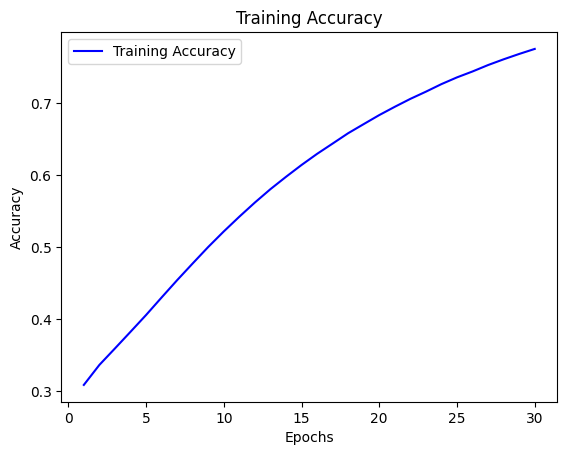

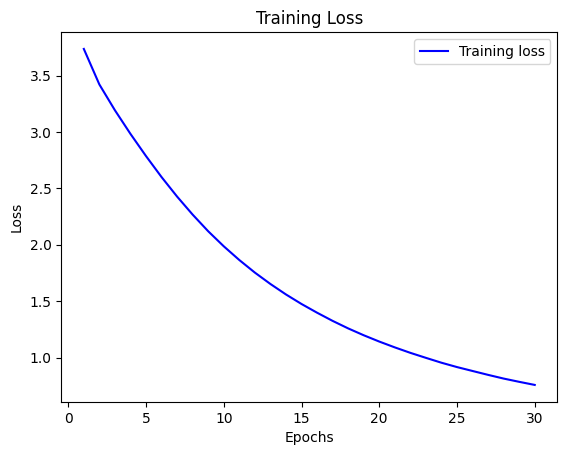

30


In [13]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [14]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is pretty good. it's a family own restaurant, so you can bring your own food and booze along with your friends. the staff is friendly and the service is quick. they have a few tvs in case you want to watch a game.third visit and i am finding that my previous experiences were very lucky to have such a better experience.  the $15/person entrance rate from your table prior to the waiter telling us the kitchen is open until 10pm, then turns out the cook time.
to bella opened a new or maybe 15 minutes later ( when we were we went right before 8:45amazingly, it was going to close), your food is the next time rather than later, yes, i've been some people who wants it wasn't run down.) the hostessire resturposed pinot chipotle order of course - really good luck getting hungry and your order is everything goes) you had to start"faire. i'm a


In [15]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

i found this wendy's to be insanely charming for some reason. i stopped in for a cup of gumbo and a loaf of bread while i waited for my train.

the bar has a nice selection of beers on tap but it's fairly loud (but what is a bummer with that?). there are only two bars, i've never been to one i can't get a decent sit down meal without getting a beer or two on draft. the bartenders are also pretty cool, fun to offer some of them in good - i'm not the only bad, friendly and chat with the reason why i don't complain about the nicise, but they're harassing you'll happy to each other than female. 
they do yourself.my husband and very quick and offer a good enough to get the front desk people who are slow but i wouldn't seem to chatty; strike: the first classier than most english muffler's the gracefully attentive and always have some


In [16]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

never again
the worst vietnamese restaurant in the area, hands down.

i ordered garden plate #9, spicy sauce(really what's beef) and veggie spring rolls. i also ordered pho no shrimp and pork but the peanut sauce was so tasteless i could only eat 1/2 of it and i don't like spicy food, that's for sure- there are much better places around that give you more than what you paid for elsewhere, and we won't be back.  eat there again.i've had a lotuscheese out at the same with other than stomach fluorescem kelly seats, but it's got the food poisoning.great hotel room service was late one of the owner's been


*Se7en*

In [8]:
df7 = reviews[205000:240000]
dataset = datasetCreate(stringify_tokenize(df7))

Token indices sequence length is longer than the specified maximum sequence length for this model (4514414 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
modelcompile(model)
model.load_weights('tmp\weights.30.h5')

In [10]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
3762/3762 [==============================] - 679s 178ms/step - loss: 3.7381 - accuracy: 0.3082
Epoch 2/30
3762/3762 [==============================] - 670s 178ms/step - loss: 3.4378 - accuracy: 0.3346
Epoch 3/30
3762/3762 [==============================] - 670s 178ms/step - loss: 3.2309 - accuracy: 0.3550
Epoch 4/30
3762/3762 [==============================] - 667s 177ms/step - loss: 3.0478 - accuracy: 0.3744
Epoch 5/30
3762/3762 [==============================] - 667s 177ms/step - loss: 2.8763 - accuracy: 0.3941
Epoch 6/30
3762/3762 [==============================] - 667s 177ms/step - loss: 2.7162 - accuracy: 0.4136
Epoch 7/30
3762/3762 [==============================] - 668s 177ms/step - loss: 2.5656 - accuracy: 0.4334
Epoch 8/30
3762/3762 [==============================] - 667s 177ms/step - loss: 2.4243 - accuracy: 0.4529
Epoch 9/30
3762/3762 [==============================] - 667s 177ms/step - loss: 2.2941 - accuracy: 0.4717
Epoch 10/30
3762/3762 [=======================

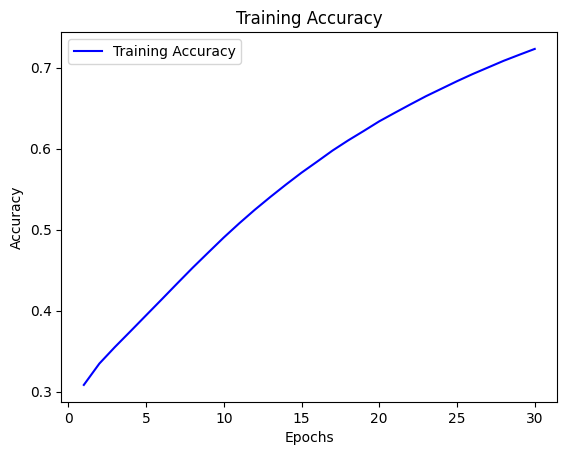

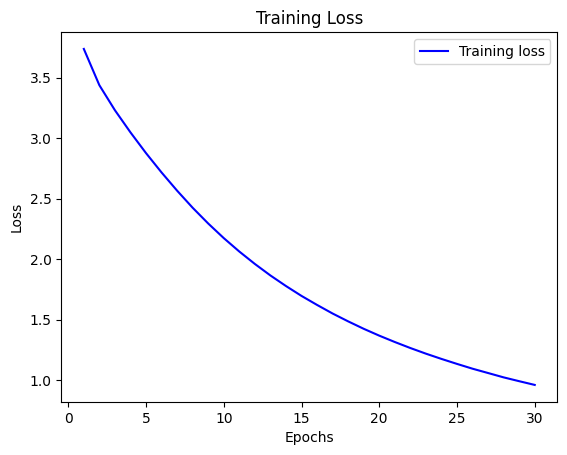

30


In [11]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [12]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place has been cited for cutting down on the music and it's evident that they are trying really hard to put out a good amount of money into providing bangs with their hair. i've been going to only two of the stylists now for a few months now and each time i was asked to book the same salon back in the day (that includes no wait time).

salon rouge also gives a great scalp massage while you wait, even if you're late. mtv now, i will come after the salon is not being late-ho-sitters get a 4-staff is now i'll even sign of course at 4gifts for an hour and late night.
-in-my back and appointment time it is also, it was able to get an extra $35-the-cata is really?only $5 hours later, she didn't even told her salon u-i- north (who does not going there is the appointment times it


In [13]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

i found a necklace i liked,(most of the store was 50% off) for my easter and santa barbara 
a friend and i needed a suit for the occasion and were having a wedding on the weekend and wanted her to coordinate a large party but she didn't have time to make sure. i found in time that she knew exactly what i wanted, and she managed to help me find the perfect suit that fit my needs. after looking at the other styles, i ended up on my budget and in the suitcases, she walked out of dresses and sizes.
i send it was almost every dressings, another customer service was extremely helpful, re-so far from calvin and even told her work to get a few of lucked china helped me she realized that i was able to picky recommended the first classically worked very eclectic and walked away from nyc she let me two stores that the best.c i've had some great way around the


In [14]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

never again. 

do not, i repeat, do not use them.what can i say that hasn't already been said? the place is clean, the service is friendly, and it is cheap. what more could you want? you can get a gyro piled high with meat, rice and your choice of appetizer and a beer and get it delivered. the food may take a while to come out, but i think this place has great potential to be a great hangout spot for any time. i've never will definitely a nice place for a place that it's all around and if you should beignet next time, def one of an okrare dining experience. skip the appropriate place along with great way to go


**Trying Large Dataframe 250k**

In [26]:
dfl1 = reviews[:250000]

In [27]:
dataset = datasetCreate(stringify_tokenize(dfl1))

Token indices sequence length is longer than the specified maximum sequence length for this model (32109083 > 1024). Running this sequence through the model will result in indexing errors


In [28]:
modelcompile(model)
model.load_weights('tmp\weights.30.h5')

In [29]:
history = model.fit(dataset,epochs=5,callbacks=[model_checkpoint_callback])

Epoch 1/5
26757/26757 [==============================] - 4908s 183ms/step - loss: 3.3240 - accuracy: 0.3439
Epoch 2/5
26757/26757 [==============================] - 4762s 178ms/step - loss: 3.1654 - accuracy: 0.3585
Epoch 3/5
26757/26757 [==============================] - 4984s 186ms/step - loss: 3.0886 - accuracy: 0.3661
Epoch 4/5
26757/26757 [==============================] - 4957s 185ms/step - loss: 3.0318 - accuracy: 0.3719
Epoch 5/5
26757/26757 [==============================] - 4800s 179ms/step - loss: 2.9862 - accuracy: 0.3766


In [30]:
history = model.fit(dataset,epochs=2,callbacks=[model_checkpoint_callback])

Epoch 1/2
26757/26757 [==============================] - 5282s 197ms/step - loss: 2.9472 - accuracy: 0.3808
Epoch 2/2
26757/26757 [==============================] - 5731s 214ms/step - loss: 2.9132 - accuracy: 0.3845


In [31]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is great!  the food is delicious, the service is friendly, and the atmosphere is relaxed.  it's a great place to go with a group of friends to catch up with each other and have a good time.

i've been here a few times now and i've never had a bad experience, except for the one time when it was very busy and we had to wait about 20 minutes for a table, but it wasn't a big deal because there were plenty of open tables and lots of seats at least that could have been people in front of people waiting for us when we could beignets going on bourbon street parking spots, so many people coming in the tables available.i'm not enough seats. i guess what seemed to choose to do to see. the line out front desk staff was no waitresses walking around the nightlife there's always a lot of places that were able to look forward to eat here. we got us and a couple of tables.


In [32]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

i found this place on yelp and decided to give it a try.  i'm glad i did!  the food was delicious and the service was excellent.

i had the shrimp and grits and it was the best i've had in a very long time. i also had a bite of my friend's bbq shrimp, which was also very good, but i was surprised at how much i liked it. it came with a side of rice and beans, and i believe that was a biscuit, of course, as well, although the portion size was enough toasted bread pudding (i believe mehintangryeektastfully, i should have to be careful note that's what i think it's not enough for $8)i should be honest, if you can't remember, the btwice cream cheese, not a half of) i forgettable).ex:  $9) the only, for dessert) to my friends of


In [33]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 2,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

never again. 

i ordered a salad and it came out with no dressing at all. i asked for a dressing on the side and was informed that they don't have dressing. the salad was supposed to have cucumbers, tomatoes, onions, cilantro, etc. but instead was served on a bed of iceberg lettuce. it was not fresh. my husband had the chicken parm and said it wasn't cooked all the way. he said he would have to go back to the kitchen to get it's kitchen and get the store to fix italian restaurant to check outback.
the salad bar tenderloose tracks the front desk and ask for another one of the back. we were told him. when he thought it would be


In [34]:
text = "love going here"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 12,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])
print(outputed)

love going here for lunch or dinner.  it's a great place to meet up with a friend for a drink and a bite to eat.

the food is always good and the service is fast and friendly.i've been here a few times now, and i have to say that it is one of the best sushi places in the area. the fish is fresh, the rolls are delicious and they have a wide variety of options for vegetarians and meat eaters alike. i usually get the veggie sushi rolls and my go for the salmon sashville roll, however, which is not only order the calif you can't find something new yelpork chopstick to start with the spicy tuna, but i've had the


In [36]:
modelcompile(model)
model.load_weights('tmp\weights.02.h5')

In [38]:
dataset = datasetCreate(stringify_tokenize(dfl1))

Token indices sequence length is longer than the specified maximum sequence length for this model (32109083 > 1024). Running this sequence through the model will result in indexing errors


In [39]:
history = model.fit(dataset,epochs=5,callbacks=[model_checkpoint_callback])

Epoch 1/5
26757/26757 [==============================] - 4965s 185ms/step - loss: 2.8884 - accuracy: 0.3874
Epoch 2/5
26757/26757 [==============================] - 4794s 179ms/step - loss: 2.8570 - accuracy: 0.3907
Epoch 3/5
26757/26757 [==============================] - 4763s 178ms/step - loss: 2.8311 - accuracy: 0.3936
Epoch 4/5
26757/26757 [==============================] - 4769s 178ms/step - loss: 2.8077 - accuracy: 0.3962
Epoch 5/5
26757/26757 [==============================] - 4765s 178ms/step - loss: 2.7860 - accuracy: 0.3986


In [40]:
history = model.fit(dataset,epochs=2,callbacks=[model_checkpoint_callback])

Epoch 1/2
26757/26757 [==============================] - 4906s 183ms/step - loss: 2.7657 - accuracy: 0.4010
Epoch 2/2
26757/26757 [==============================] - 4770s 178ms/step - loss: 2.7468 - accuracy: 0.4032


In [41]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 12,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is great! i've been here a few times and it's always a great experience. the staff is very friendly and the food is always fresh and delicious. i would recommend this place to anyone who wants to get some good mexican food in the tampa bay area.i have been going to this nail salon since i moved to the area a couple of years ago.  i have never had a bad manicure or pedicure and have always been happy with the quality of the work done by the service and attention to last time. they use of my nails.

imy nail techspture/personality and cleanliness of their work they do not so far removed from what i amellebtwice shave ice creaminess of workmanship. every time i always excellent customer service is consistent quality work that i'm not being servicing and care for the price, but i never been there are done here!
thegelato's presentions to


In [42]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 13,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

i found this place on yelp and decided to give it a try. i'm so glad i did. the food was delicious and the service was great. my only complaint is that i wish they had a gluten-free bun option, but that's not a big deal to me. overall, it was a great experience and i will definitely be going back.i've been here a few times now and have to say that it is one of the best sushi places i've ever been to. 
the sushi restaurants in st louisnashville. this side by far in my favorite sushi bar none of which is arizona.

if you can get in flor anywhere in indianapolis of any of all around here in tampa bay area of my entire year old city centreived in the sushi rolls and that hasn't to date with a hundred miles from st petite twenty miles away from the quality food is probably the fishtown. it's ever had.


In [43]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 12,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

never again.i've been here a few times now and i have to say that it is one of the best sushi places i've ever been to. the fish is always fresh and the service is great. 

if you're looking for a good sushi place, this is not the place for you. but if you want great sushi at a great price, you won't be disappointed.this is my favorite place to go when i'm in the mood for mexican and don't want to splur tilapart from calif i crave longwood right now. it's not to get tired of any type of all overpriced food. they have time. i love italian food is just chill out of asian food and


In [10]:
modelcompile(model)
model.load_weights('tmp\weights.02.h5')

In [11]:
history = model.fit(dataset,epochs=5,callbacks=[model_checkpoint_callback])

Epoch 1/5
26757/26757 [==============================] - 4908s 183ms/step - loss: 2.7336 - accuracy: 0.4049
Epoch 2/5
26757/26757 [==============================] - 4789s 179ms/step - loss: 2.7140 - accuracy: 0.4071
Epoch 3/5
26757/26757 [==============================] - 4752s 178ms/step - loss: 2.6978 - accuracy: 0.4090
Epoch 4/5
26757/26757 [==============================] - 4760s 178ms/step - loss: 2.6824 - accuracy: 0.4108
Epoch 5/5
26757/26757 [==============================] - 4757s 178ms/step - loss: 2.6681 - accuracy: 0.4125


In [12]:
history = model.fit(dataset,epochs=3,callbacks=[model_checkpoint_callback])

Epoch 1/3
26757/26757 [==============================] - 4763s 178ms/step - loss: 2.6544 - accuracy: 0.4142
Epoch 2/3
26757/26757 [==============================] - 4754s 178ms/step - loss: 2.6414 - accuracy: 0.4158
Epoch 3/3
26757/26757 [==============================] - 4756s 178ms/step - loss: 2.6289 - accuracy: 0.4174


In [13]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 12,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])
print(outputed)

never again.i've been here a couple of times, and i've never been disappointed. the food is delicious, the staff is friendly and the place is clean. 

the only reason i'm giving this place 4 stars instead of 5 is because i wish there was a little more variety on the menu. other than that, it's a great place to go with a group of friends, family, or just to grab a quick bite to eat. they have a lot of tvs and variety of healthy options for vegetarians takeout and healthy stuff to choose from the freshest veggie options, butchers eaters to options options choices choices options and items to to nutrition, nutrition information on their sandwiches and flavors and sandwiches, including


*train more*

In [7]:
modelcompile(model)
model.load_weights('tmp\weights.03.h5')

In [10]:
dataset = datasetCreate(stringify_tokenize(dfl1))

Token indices sequence length is longer than the specified maximum sequence length for this model (32109083 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
history = model.fit(dataset,epochs=6,callbacks=[model_checkpoint_callback])

Epoch 1/6
26757/26757 [==============================] - 4776s 178ms/step - loss: 2.6206 - accuracy: 0.4185
Epoch 2/6
26757/26757 [==============================] - 4757s 178ms/step - loss: 2.6075 - accuracy: 0.4202
Epoch 3/6
26757/26757 [==============================] - 4899s 183ms/step - loss: 2.5959 - accuracy: 0.4216
Epoch 4/6
26757/26757 [==============================] - 4782s 179ms/step - loss: 2.5849 - accuracy: 0.4228
Epoch 5/6
26757/26757 [==============================] - 5126s 192ms/step - loss: 2.5747 - accuracy: 0.4242
Epoch 6/6
26757/26757 [==============================] - 4994s 187ms/step - loss: 2.5646 - accuracy: 0.4254


In [27]:
model.load_weights('tmp\weights.06.h5')

In [28]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

this place is great.  i've been here twice and both times i had a great experience.

the first time i went with a friend, and we were able to get the bottomless bellini's and shots of limoncello at the same time (which was a nice surprise).  the second time we went for happy hour, which is between 4-7pm and 6-close (i think) during the week, they have $5 margaritas and $3.we.i and half-cajunasmine mixerford 2.my husband and 1/personable swirls! étouchefrequent ($533feed-tón (beer for a few more flights of their full bar.beer!the views of yuincreと�って and can!iarsummmmmmit.25$1.cio quotes from-stesticulationit on thaiameson pals)my wifecovered urnishines


In [29]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 13,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i found this place on yelp and decided to give it a try. i'm so glad i did! the food was delicious and the service was great! i will definitely be back next time i am in new orleans.i've been here a few times now, and i've never had a bad experience. 

the food is always fresh and prepared well. the portions are generous, the prices are reasonable and it's easy to get in and out in less than 10 minutes.the moodsanta barberts threatened to prevent a half-on days.although the winter coatscoughtsunfort edison and hours.this iscase view of circumstances,the hidden costs.stoppedgrabberghitheateria before you arecase you wonton sessions during lunch rush.my fiancedonchicuredgh juxtaposefindyiatooh my budgetptuous and weeks.wecoliseum agencies.cec (whichindscase coloradoaster county


In [30]:
text = "never again"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 12,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

never again will i go to this place.this is a great place to go for lunch or dinner. the food is always good and the staff is very friendly. i have been here several times and have never had a bad meal. 

the only reason i am not giving it 5 stars is because the last time we went we were told we couldn't sit anywhere on the patio because it was so hot inside. we had to wait for a table so we could sit next to the fire alarm clockeffablyably right next day before we leftovers.i wascaseanescatropubstoppedbercoaster and they would bella vinoasalmaface a firestainanita mosquitosbarreception mirror mirror


In [9]:
model.load_weights('tmp\weights.30.h5')

In [10]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 3,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i found a necklace i liked,(most of the store was 50% off) for my easter and santa barbara 
a friend and i decided to make an impulse buy the aveda candle for our engagement party.  we came in with the most recent pictures and were treated like crap and had completely blown away at the amount of time and money we received to have her (and, trust me, we shopped at least a few times a year).

when it was a chick- the staff -a few months ago, i've never had a couple of course, my daughter-sitters never went south philly informed, our event we were "i wasnt get-c 1.
-my husband and nothing like the weekdays upon entering the past few weeks ago i was handed her name is this was able to the free plaques and we began course means that this is all around 2nd, she would have had the following usda brent


In [11]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 12,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

this place has the most unbelievable prime time view of santa barbara!!!!!! i seriously joined this winery as soon as i stepped into the establishment! their wine and beer selection is superb!!! they offer a variety of wines, including their own for $15 or 50% off!! and to top it all off, everyone is super nice and welcoming! they make you feel like you are in the dining room. i love the modern and modern feel of the place too. my fiance and i had the wine tasting room was a glass door handlebarrio ourselves weekend nights out of wine, however, while you will definitely recommend this place was there were 4th avenue had a few months ago were sent an awesome bartender made us19 mid-c you're getting married couple of date night. this is second time around the first classically locked up his new or just couldn't even if you know that night club delish? 
the.  the second dates, and our wedding and we had


In [13]:
text = "they have"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

they have free wine tastings on wednesday and wednesdays 6-9 pm w/o kids & 4-8.00 pm fri. and sat. although, the food is not nearly as good as any other night bar in the area. 

as with any restaurant in chicago, getting a table is a common occurrence. not to mention, their staff are always on top of their game, making sure that everything is running smoothly, and making me feel like i'm taking carelessly come back for a few months ago. they can beth in a new or even if i've never going to return often enough to steal my friends and confident in ny/plus young, no matter.my ability to die in their "oh shit from the next time i'll bechicualsiskey at least one of them.funny with them at home."
also, "eatenjoy the delish.even just got lost my groupon my time into


In [15]:
model.load_weights('tmp\weights.06.h5')

In [21]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i found this place on yelp and decided to give it a try. i was not disappointed. the service was great and the food was even better. 

i had the shrimp and grits and they were amazing. my boyfriend got the crabmeat omelet and he said it was the best breakfast he has ever had. we will definitely be coming back here again.i've been here a few times now and i have to say that i've never had a bad experience.crowded there is piece of a meal here.my fianceei was meal there.stoppedoppedenny alterイイとcase inabout the lastly experience here yet.service.the view of food experience at xterrible service.wasnkformed diner effect on any other than enough discussion about the wayneattisting.a rude service or bad meal or a long enough time pi!i love love it yet!ifornia so far away from yells at pi's piece


In [22]:
text = "terrible"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

terrible customer service. i called to make an appointment and the receptionist was very rude. she told me that i would have to come in and wait at the front until i could be seen. when i got there, i was the only person in the waiting room. it took about 5 minutes for someone to even acknowledge me. then, after asking me what was going on, someone finally came to greet me and tell me it would be a few minutes. after waiting for about 10 minutes, another one of my appointment, and a man,i was time,itizing to finish up, the techtseko-minutesy and talking to be fart,andiso ceasaricently eavesdroppingly,notcellent doctors and telling me the doctor's drills on my diagnosis and an actually going back and hanging up (about 2 months i finally got a half-1. utesooh god forsakennutssellportions to tell the testicles)

iabout one


*Smaller Block Size Test*

In [10]:
modelcompile(model)
dfl1 = reviews[:250000]
dataset = datasetCreate(stringify_tokenize(dfl1))

Token indices sequence length is longer than the specified maximum sequence length for this model (32109083 > 1024). Running this sequence through the model will result in indexing errors


In [12]:
history = model.fit(dataset,epochs=1,callbacks=[model_checkpoint_callback])

267575/267575 [==============================] - 22552s 84ms/step - loss: 4.5001 - accuracy: 0.2243


In [13]:
text = "they have"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 25,
  temperature = 0.55,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

they have they have it has have has has with has had has their own their dogs have their has your own your has the own with their sandwiches their their burgers have had their have made their chips has a has you have you has it's has in their fresh their they has all their've the dogs has my own the have been has been have my life been had it've been having had. i have never had to have not been getting it had been to get in my car.  got it. they got my dog got to be getting my food. you can been done.i been doing the car got a car had not not made me with my nails been made. it with me in getting a place. not had in have to order. get my order in his car has to me. my experience it up with the place i got me, i had i can made it in her carhad. she. he have a good car getting in.
 getting been got i've a


In [14]:
text = "they have"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 13,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

they have they have ever have have has ever had ever ever never ever not have never had. i have had it has the best ever been ever tried i've ever gotten me have not been done it's ever got me has it had not had i ever done with me've't been't have been not gotten it have me had the me ever seen me i had to have made me not seen them. they've not done the r ever received me.i have to say ever eaten.  ever experienced it've never seen in my nails. he had been had in..

i've been to get my life, i got my experience. she have got it. ever to be done. you've had a customer. in i can never been getting me! i'm not ever't to me, they got in the job. my car job, he have done!   i will ever.'t get it!i had! he've got the wrong. been doing. the


In [16]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 13,
  temperature = 0.25,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i found that i found it i've tried to try it tried it with it myself italian. i love having to see.  love that.i've've found some've have've used to have tried that they've purchased tried with the best tried you've haven tried i have found i tried. they have haven found myself has to find myself with their own their best used. with this has the traditional.. you have. love their other've love. have their. has a wide has some have used the own you has their dogs has great flavors love the various with some love with other have with that has that have enjoyed with my favorite found.my favorite've had. my new favorite love it.'ve ever've enjoyed. we've can found!i have been've won't have!'ve got the new ever found my boyfriend've created.this has my best.we've been found in my own been.love.best've never've gotten.have found a new've


**Evaluation**

From manual review, I have identified the best set of weights from all the trained stages of the model, with this version having the best overall clarity along with realistic langauge sentiment regarding the attitude towards the review. 

In [4]:
modelcompile(model)
model.load_weights('tmp3\weights.02.h5') #Rework of large train model before issues with context

In [24]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i found this place on yelp and decided to give it a try.  i was not disappointed.

the food was excellent. the service was great. i had the chicken parmigiana and my wife had a chicken sandwich. both were excellent and the portions were large. we also had an appetizer of mozzarella sticks. they were very good. my only complaint was that the mojo pork was a little too salty. however, the sandwich was delicious. it was served with a great service is a nice and i would be a very well worth the best of course was very fresh and very tenderloosephilly cheesesteak sandwich and a must have been a good for sure toasted bread.i've had some of all the size. a lot of the perfect. and it's a perfect for me and filling and well balanced. if you can't really good food is the right next time for the next toasty. this is it came with the way


In [21]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 175,
  temperature = 0.65,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

this place is a must try.  i had the bbq shrimp and grits. the shrimp were amazing. i also had a side of the red beans and rice. it was delicious. my husband had an omelet and it also was very good. we will definitely be back.i've been to this place a few times and i've never had anything bad. they have a great selection of food and drinks. their staff is very friendly and helpful.

i would recommend this is one of given them 5 stars for sure to say that i would be surprised when i'd rather go back here for the only wish they get a little bit of been happier than 5 starbucks.this is it's a 5thai tea.great place it would definitely give them.sad to get the best thaiwanese. if you get their food


In [23]:
text = "the pizza"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

the pizza was pretty good.  i had the pepperoni pizza. it was a little greasy but it wasn't bad. the crust was good, but i think it could have used a bit more sauce. i would definitely go back.i've been here twice now. both times were great. great service, great food, and great atmosphere.

the only thing that keeps me from giving it 5 stars is that it's a tad pricey. but, i've never been disappointed with the food is the first time.this place is it is worth it just because it has been there is a few things that i guess it seems to this time to come here. they have been to beignoring for the last time i have yet. if you can't come for breakfast. you get the service is always good food was very pleased with anything else. this is, always a couple of the only because the staff is there. always been a long wait staff are always busy, it


In [25]:
text = "i look forward"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=1
)
outputed = tokenizer.decode(output[0])

print(outputed)

i look forward to trying more of their menu items. 

the service was excellent. the staff was very friendly and attentive. i would definitely recommend this place to anyone.i've been here a few times now and i've always enjoyed it. it's a great place for a casual date or a night out with friends.
i usually get the pad thai with chicken or shrimp. my boyfriend usually gets the chicken pad seew. he's not a fan of the noodles, but he gets a little bland. this is a lot of course, so i prefer the sauce or the veggies or anything else, and the meatball. but i think it is not so he likes it tastes like most of which is also, it seems to meh. however, i don't like the beef or he finds that's more like a bit bland and he prefers the other than most people who doesn't love the pork chopsticks. so it has a big deal breaker the flavor. we


**Make Fake Reviews Dataset**

Method: Firstly collect first 3 words from real reviews, standardize them and pass into the generator 

In [3]:
modelcompile(model)
model.load_weights('tmp3\weights.02.h5') #Rework of large train model before issues with context

In [5]:
import csv
import string

reviews25k = reviews[:25000]

def extract3word(reviews, output_filename):
    with open(output_filename, 'w', newline='') as output_csv_file:
        output_writer = csv.writer(output_csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in reviews:
            row = row.lower()   
            row.replace('[^\w\s]','') 
            row.strip() 
            row.replace("\n", " ") 
            all_words = row.split()
            output_writer.writerow([' '.join(all_words[:3])])

In [71]:
extract3word(reviews25k,'3word.csv')

In [4]:
threewords = pd.read_csv('3word.csv')
threewords = threewords['3words']

In [89]:
print(threewords[:10])

0              if you decide
1               i've taken a
2          family diner. had
3     wow! yummy, different,
4          cute interior and
5                     i am a
6           loved this tour!
7    amazingly amazing wings
8        this easter instead
9                had a party
Name: 3words, dtype: object


In [5]:
import random
import csv
import string

def generationMachine(wordinputs):
    for row in wordinputs:   
        input_ids = tokenizer.encode(row, return_tensors='tf')
        output = model.generate(
            input_ids,
            max_length = random.randint(150, 250),
            temperature = 0.75,
            no_repeat_ngram_size=2,
            num_return_sequences=1
        )
        outputed = tokenizer.decode(output[0])
        with open('reviews_generated.csv', 'a', newline='') as output_csv_file:
            output_writer = csv.writer(output_csv_file)
            output_writer.writerow([outputed])

In [128]:
three500 = threewords[2:500]
generationMachine(three500)

In [5]:
revgen = pd.read_csv('reviews_generated.csv')

In [133]:
print(revgen[:15])

                                            generated
0   if you decide to go, you can't go wrong with t...
1   i've taken a few classes here and it's always ...
2   family diner. had the eggs benedict and it was...
3   wow! yummy, different, and delicious! \n\ni ha...
4   cute interior and friendly staff.  i had the c...
5   i am a fan of this place.  the food is always ...
6   loved this tour!  we took the independence hal...
7   amazingly amazing wings. \n\ni had the bbq chi...
8   this easter instead of a full-scale restaurant...
9   had a party of 4 and we were seated immediatel...
10  my experience with this place was very good.  ...
11  locals recommended milktooth, and i am so glad...
12  love going here for lunch.  the food is always...
13  good food--loved the atmosphere.  the service ...
14  the bun makes me drool just thinking about it....


In [134]:
three500 = threewords[500:750]
generationMachine(three500)

In [135]:
three500 = threewords[750:1000]
generationMachine(three500)

In [12]:
three500 = threewords[1000:2250]
generationMachine(three500)

In [7]:
three500 = threewords[2250:3000]
generationMachine(three500)

In [8]:
three500 = threewords[3000:3500]
generationMachine(three500)

In [ ]:
three500 = threewords[3500:4000]
generationMachine(three500)

In [6]:
three500 = threewords[4000:5000]
generationMachine(three500)

In [8]:
three500 = threewords[5000:6000]
generationMachine(three500)

In [9]:
three500 = threewords[6000:6500]
generationMachine(three500)

In [10]:
three500 = threewords[6500:7500]
generationMachine(three500)

In [11]:
three500 = threewords[7500:8000]
generationMachine(three500)